In [4]:
import requests
from PIL import Image
import numpy as np
from io import BytesIO
import matplotlib.pyplot as plt

In [2]:
# Parameters
obj_name = 'CGCG_049-065'
ra = 228.4718924   # Right Ascension in degrees
dec = +4.46126   # Declination in degrees
size = 0.033  # Size in degrees (0.05 degrees ≈ 3 arcmin)
layer = 'ls-dr9'

# Convert size to pixels (Legacy Surveys default: 0.262 arcsec/pixel)
pixel_scale = 0.1  # arcsec/pixel
size_pix = int((size * 3600) / pixel_scale)

# Construct the URL for the Legacy Survey Cutout Service АПИ (Application Programming Interface)
url = f"""https://www.legacysurvey.org/viewer/jpeg-cutout?ra={ra}&dec={dec}
&layer={layer}&pixscale={pixel_scale}&size={size_pix}"""

# Download the image
response = requests.get(url)

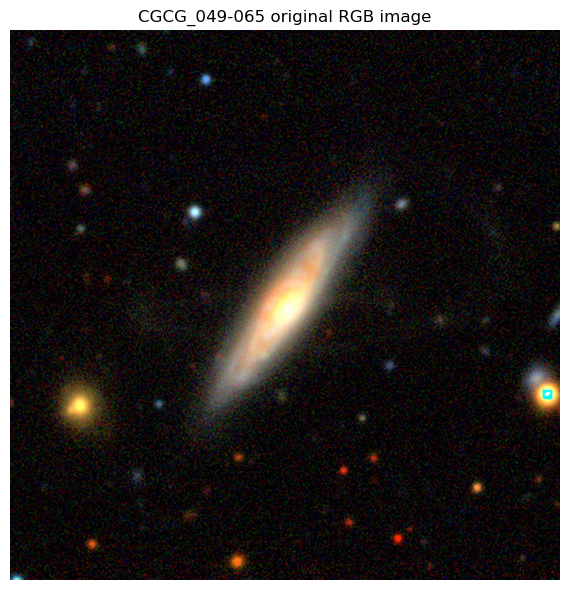

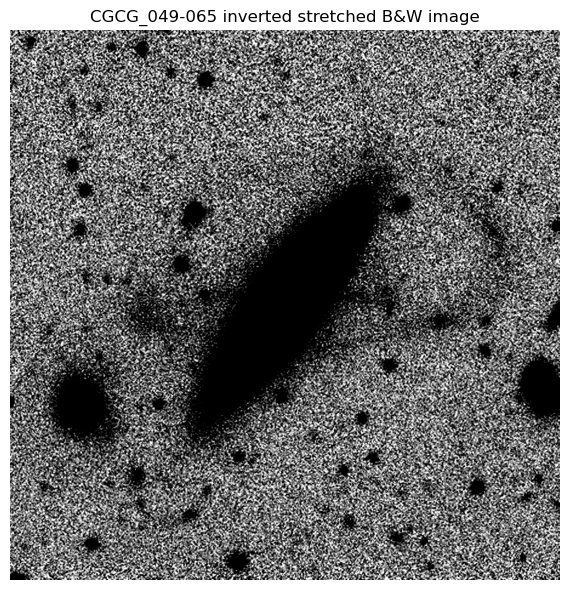

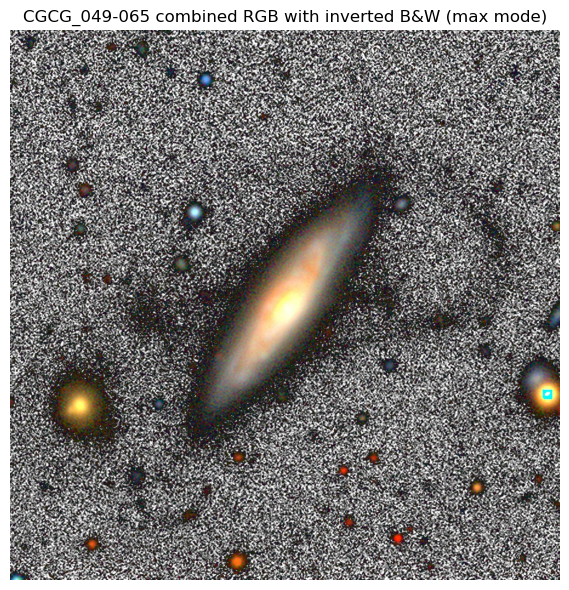

In [7]:
# Load the image and convert it to a NumPy array
image = Image.open(BytesIO(response.content))
image_array = np.array(image)
pmin = np.percentile(image_array, 40)  # 5th percentile
pmax = np.percentile(image_array, 99.99)  # 95th percentile
stretched_array1 = np.clip((image_array - pmin) / (pmax - pmin) * 255, 0, 255).astype(np.uint8)
image1 = Image.fromarray(stretched_array1)

# Ensure the image has 3 color channels
if image_array.shape[-1] != 3:
    raise ValueError("The input image must have 3 color channels (RGB).")

# Apply a stretch to the original image (linear stretch)
pmin = np.percentile(image_array, 10)  # 5th percentile
pmax = np.percentile(image_array, 70)  # 95th percentile
stretched_array = np.clip((image_array - pmin) / (pmax - pmin) * 255, 0, 255).astype(np.uint8)

# Create a B&W image by taking the median across RGB channels
bw_array = np.median(stretched_array, axis=2).astype(np.uint8)
bw_array = 255 - bw_array  # Invert the grayscale image
bw_image = Image.fromarray(bw_array, mode="L")  # Create B&W PIL image

# Combine the original RGB image with the B&W image using MAX mode
# Expand the B&W image to match the shape of the RGB image
bw_array_expanded = np.expand_dims(bw_array, axis=2).repeat(3, axis=2)  # Repeat for R, G, B channels

# Take the maximum across the original RGB and expanded B&W
combined_array = np.maximum(stretched_array1, bw_array_expanded).astype(np.uint8)

# Convert the combined array back to a PIL image
combined_image = Image.fromarray(combined_array)

# Save and display the Original Image
plt.figure(figsize=(6, 6))
plt.imshow(image1)
plt.title(f"{obj_name} original RGB image")
plt.axis('off')
plt.tight_layout()
plt.savefig(f'plots/{obj_name}_decals_original.png', bbox_inches='tight', facecolor='white')
plt.show()  # Close the figure to avoid overwriting

# Save and display the Stretched B&W Image
plt.figure(figsize=(6, 6))
plt.imshow(bw_image, cmap='gray')
plt.title(f"{obj_name} inverted stretched B&W image")
plt.axis('off')
plt.tight_layout()
plt.savefig(f'plots/{obj_name}_decals_inverted_bw.png', bbox_inches='tight', facecolor='white')
plt.show()

# Save and display the Combined Image
plt.figure(figsize=(6, 6))
plt.imshow(combined_image)
plt.title(f"{obj_name} combined RGB with inverted B&W (max mode)")
plt.axis('off')
plt.tight_layout()
plt.savefig(f'plots/{obj_name}_decals_combined.png', bbox_inches='tight', facecolor='white')
plt.show()


